<a href="https://colab.research.google.com/github/KevinLolochum/Deep-Learning-TF-Keras-Theano-PyTorch-/blob/master/predicting_defaulters_Using_Neural_Nets_(_TF_Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

High level API solution (Keras)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


Mounting Drive

In [36]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data is relatively  clean but the goal of this colab is not data cleaning

In [37]:
df = pd.read_csv('/content/gdrive/My Drive/Risklab.csv', delimiter = ',')
df.head(2)

,Credit_Limit,Sex,Education,Marital_Status,Age,Jan_Repay_Status,Previous_Payment_Prior_Jan,Jan_Statement,Feb_Repay_Status,Previous_Payment_Prior_Feb,Feb_Statement,Mar_Repay_Status,Previous_Payment_Prior_Mar,Mar_Statement,Apr_Repay_Status,Previous_Payment_Prior_Apr,Apr_Statement,May_Repay_Status,Previous_Payment_Prior_May,May_Statement,Jun_Repay_Status,Previous_Payment_Prior_Jun,Jun_Statement,July_Payment_Status
0,9600.0,1.0,3.0,3.0,32.0,6.0,110.0,138.0,5.0,2847.0,5298.0,11.0,1692.0,NaN,7.0,331.0,1080.0,12.0,535.0,1671.0,3.0,4800.0,6799.0,1.0
1,14400.0,2.0,3.0,2.0,30.0,-2.0,0.0,132.0,-2.0,0.0,0.0,-2.0,0.0,0.0,-2.0,0.0,0.0,-2.0,45.0,0.0,-2.0,136.0,45.0,0.0


In [38]:
#dtypes are all float
df = df.dropna(axis = 0, how='any')
df.shape

(30522, 24)

Checking the min and max for each column to ensure there are no outliers

Value minimums and maximums are given in the metadata.

In [39]:
names = list(df.columns)
for name in names:
  s = str(name)
  print('The min of {col} is {min} while the max is {max}'.format(col = s, min = df[s].min(), max = df[s].max()))

The min of Credit_Limit is 200.0 while the max is 40100.0
The min of Sex is 0.0 while the max is 8.0
The min of Education is 0.0 while the max is 6.0
The min of Marital_Status is 0.0 while the max is 4.0
The min of Age is 15.0 while the max is 102.0
The min of Jan_Repay_Status is -2.0 while the max is 12.0
The min of Previous_Payment_Prior_Jan is 0.0 while the max is 34942.0
The min of Jan_Statement is -6623.0 while the max is 38580.0
The min of Feb_Repay_Status is -2.0 while the max is 12.0
The min of Previous_Payment_Prior_Feb is 0.0 while the max is 67370.0
The min of Feb_Statement is -2791.0 while the max is 39357.0
The min of Mar_Repay_Status is -2.0 while the max is 12.0
The min of Previous_Payment_Prior_Mar is 0.0 while the max is 35842.0
The min of Mar_Statement is -6291.0 while the max is 66564.0
The min of Apr_Repay_Status is -2.0 while the max is 12.0
The min of Previous_Payment_Prior_Apr is 0.0 while the max is 24840.0
The min of Apr_Statement is -6800.0 while the max is 35

Comparing with metadata it seems like Education, Sex and Marital_Status have unkown values.

In [40]:
# Unknown values in sex are neglible. Education and Marital status have a value for unknown values so I will replace

df = df.replace({'Education': {5.0:4.0, 6.0:4.0},
                  'Marital_Status':{4.0:3.0}})
df.shape



(30522, 24)

In [41]:
# Normalize the data

from sklearn.preprocessing import MinMaxScaler


# Convert to Numpy array so I can normalize the features, no need to normalize labels
Values = df.values
Features = Values[:, :-1]
Labels = Values[:, -1]
Features = Features.astype('float32')
Scaler = MinMaxScaler(feature_range=(0, 1))
Normalized = Scaler.fit_transform(Features)

# Change datatype of Labels to categorical and merge the two dataframes again
df1 = pd.DataFrame(Labels).astype('uint8')
df2 = pd.DataFrame(Normalized)
df3 = pd.merge(df2, df1, left_index= True, right_index = True)

#Deleting outliers in category
df3 = df3[(df3['0_y'] <= 1)]
df3.head(3)


,0_x,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,0_y
0,0.355890,0.250,0.75,0.666667,0.172414,0.000000,0.000000,0.149437,0.000000,0.000000,0.066219,0.000000,0.000000,0.086350,0.000000,0.000000,0.160139,0.000000,0.002638,0.080640,0.000000,0.006431,0.261839,0
1,0.197995,0.125,0.25,0.666667,0.160920,0.071429,0.003806,0.146672,0.071429,0.025234,0.069351,0.071429,0.000000,0.107501,0.071429,0.030233,0.160045,0.071429,0.029189,0.099157,0.071429,0.018017,0.270504,0
2,0.062657,0.250,0.50,0.333333,0.183908,0.142857,0.002976,0.210473,0.142857,0.002078,0.134170,0.142857,0.003348,0.126127,0.142857,0.001610,0.227068,0.142857,0.003517,0.110064,0.142857,0.000898,0.283126,0


In [8]:
df3.shape

(30521, 24)

Modelling

In [42]:
# Split the data into training and testing

values = df3.values
splt = int(len(values)*0.8)
X_train = values[:splt, :-1]
Y_train =values[:splt, -1]
X_test =values[splt:, :-1]
Y_test =values[splt:, -1]

# Shape of the data

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)



(24416, 23) (24416,) (6105, 23) (6105,)


Gaussian Naive Bayes GNB.

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

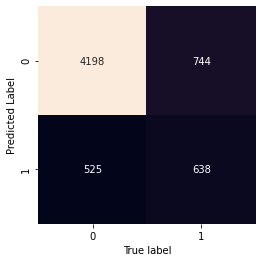

In [ ]:
# Predicting Y values using trained model

Y_pred = model.predict(X_test)

# Model accuracy using confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
plt.xlabel('True label')
plt.ylabel('Predicted Label');

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, Y_pred)

0.7921375921375922

Model attains an accuracy of ~80% in classifying the customers, this is not bad.

Bagging classifier

Bagging is an ensembe method that combines the predictions of weak classifiers like decision trees that are trained on subsets of data.
The goal is to reduce variance, which makes sense for this data that has high cardinality. In this example I am using sample vector classifier (SVC).

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(base_estimator= SVC(), n_estimators = 10, random_state = 0).fit(X_train, Y_train)

# predict Y
ypred = model.predict(X_test)

# Model performance
accuracy_score(Y_test, ypred)


0.8149058149058149

Achieves slightly better than Guassian Naive Bayes

Gradient boosting using XGBoost

This method fits learners (decision trees) in a sequence so that each learner is an improvement of the previous learner. When an input is misclassified, more weight is placed on it in the subsequent learner to improve accuracy.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from numpy import mean, std

model = XGBClassifier(objective = 'binary:logistic', )
cv = RepeatedStratifiedKFold(n_splits = 20, n_repeats = 3, random_state=1)
n_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', 
                           cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.817 (0.018)



Neural nets might also improve the accuracy of our model.

Deep Learning Neural Nets

In [43]:
# Using Neural Nets
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim = 23, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [44]:
# Compiling
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Epoch 1/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6244 - accuracy: 0.7758 - val_loss: 0.5811 - val_accuracy: 0.7736
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5565 - accuracy: 0.7758 - val_loss: 0.5371 - val_accuracy: 0.7736
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5286 - accuracy: 0.7758 - val_loss: 0.5243 - val_accuracy: 0.7736
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5159 - accuracy: 0.7758 - val_loss: 0.5113 - val_accuracy: 0.7736
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5038 - accuracy: 0.7761 - val_loss: 0.5003 - val_accuracy: 0.7731
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.4937 - accuracy: 0.7783 - val_loss: 0.4920 - val_accuracy: 0.7762
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.4870 - accuracy: 0.7840 - val_loss: 0.4877 - val_accuracy: 0.7797
Epoch 8/100


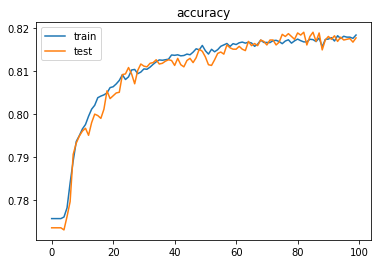

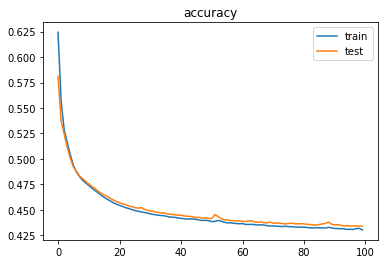

In [45]:
# training and predicting
epochs = 100
Batch_size = 2000

history = model.fit(X_train, Y_train, epochs = epochs, batch_size = Batch_size,
                    validation_data=(X_test, Y_test), verbose = 1, shuffle = True)

# Plotting accuracy and loss

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('accuracy')
plt.legend()
plt.show()

Test accuracy stops improving around 60 epochs when accuracy is around 82%. The NN model is slightly better than the other ML classifiers above.

In [ ]:
# Predicting the defaulters in a specific month.
Predict = model.predict_classes(Newdata)

Saving the model using JSON

In [46]:
from keras.models import model_from_json
import os

# serialize model to jason
model_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)

# serializing weights to HDF5
model.save_weights('model.h5')
                    



In [47]:
# Retriving model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Loading weights
loaded_model.load_weights('model.h5')

In [48]:
# Evaluationg the loaded model

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 81.77%


Score is exactly the same as our last score of 81.61%, meaning model was successfully saved.

Deploying the model using TensorFlow Lite.

Model deployment in tensorflow lite is done using the steps below

In [50]:
import tensorflow as tf

import pathlib

#1 Exporting the saved model

export_dir = '/tmp/saved_model'
tf.saved_model.save(loaded_model, export_dir=export_dir)

#2 Converting model to a TFflatbuffer file with quantizition
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
      # Quantization reduce memory needed without sacrificing speed and accuracy
      # Optimize for size optimizes the weights of the model
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

#3 Saving the converted model
tflite_model_file = pathlib.Path('/tmp/foo.tflite')
tflite_model_file.write_bytes(tflite_model)



INFO:tensorflow:Assets written to: /tmp/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/assets


6240

Testing if model actually work in production by using tensorflow lite interpreter

In [79]:
# Loading tflite model to interpreter and allocating tensors
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Get input and outputs tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], X_test[25].reshape(1,23))
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

#Comparing actual y and predicted by our TFlite deployed model
print('Model predicted that the label is %.0f, the true label was %.0f' % (tflite_results, Y_test[25]))



Model predicted that the label is 0, the true label was 0


Model correctly predicts the label of the 25th customer is zero. Which means our customer will pay on time in the coming month. Model can now be deployed to device, cloud or web. 

In [ ]:
# Downloading the TFlite model

#try:
#  from google.colab import files
#  files.download(tflite_model_file)
#except:
#  pass